# Exercise 1.1: Markov Chain Monte-Carlo of a single polymer

In [1]:
from pathlib import Path

import scipy.interpolate
import numpy as np
import numba
from tqdm.notebook import tqdm as tqdm_
import tqdm.contrib.concurrent
import matplotlib.pyplot as plt

import soft_matter.sample

In [2]:
NUM_SEGMENTS = 16
SPRING_CONSTANT = 3 * (NUM_SEGMENTS - 1) / 2

np.random.seed(42)  # make experiments reproducible
data_dir = Path.cwd() / ".." / "data"
figure_dir = Path.cwd() / ".." / "report" / "figures"

### Show the fields in the micella

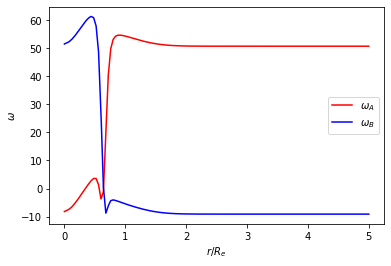

In [3]:
pos, phobic, philic = np.loadtxt(data_dir / "omega.dat", delimiter=" ", skiprows=1, dtype=np.float64).T
field_A = scipy.interpolate.interp1d(pos, phobic, fill_value=phobic[-1], bounds_error=False)
field_B = scipy.interpolate.interp1d(pos, philic, fill_value=philic[-1], bounds_error=False)

r = np.linspace(0, 5, num=1_000)
plt.plot(r, field_A(r), label="$\\omega_A$", color="r")
plt.plot(r, field_B(r), label="$\\omega_B$", color="b")
plt.ylabel("$\\omega$")
plt.xlabel("$r / R_e$")
plt.legend()

In [4]:
@numba.njit
def total_bond_energy(polymer) -> float:
    """Calculate the energy of a polymer stored in it's bonds."""
    diffs = polymer[1:, :] - polymer[:-1, :]
    summed = np.sum(diffs * diffs)
    return summed * SPRING_CONSTANT

@numba.njit
def polymer_step(polymer):
    """Propose a step on a polymer with a single segment displacement."""
    new_polymer = polymer.copy()
    selected_index = np.random.choice(NUM_SEGMENTS)

    step_length = 1 / np.sqrt(NUM_SEGMENTS - 1)
    random_step = np.random.rand(3) * 2 - 1
    displacement = random_step * step_length
    new_polymer[selected_index, :] += displacement

    return new_polymer

## Simulate without external fields

In [16]:
max_steps = 1_000_000
drop_start = 200_000
energy = total_bond_energy

old_polymer = soft_matter.sample.sample_initial(NUM_SEGMENTS)
ens = [old_polymer]
energy_old = energy(old_polymer)
for step in tqdm_(range(max_steps * NUM_SEGMENTS)):
    new_polymer = polymer_step(old_polymer)
    energy_new = energy(new_polymer)

    acceptance_rate = np.exp(energy_old - energy_new)
    mc_number = np.random.rand()
    if mc_number < acceptance_rate:  # accepted
        ens.append(new_polymer)
        old_polymer = new_polymer
    else:
        ens.append(old_polymer)  # rejected

ens = np.array(ens[drop_start * NUM_SEGMENTS:])

  0%|          | 0/15000000 [00:00<?, ?it/s]

2022-10-18T19:47:28.775890+0200 - Timed out waiting for syncing to complete.
2022-10-18T19:47:35.423138+0200 - Timed out waiting for syncing to complete.


### Analyze the simulation results

x: mean=-0.0000 std=0.7927
y: mean=-0.0283 std=0.7693
z: mean=-0.0032 std=0.7667


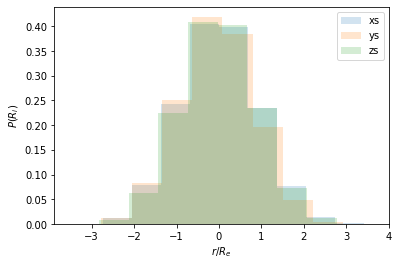

In [17]:
end_to_end = ens[:, 0, :] - ens[:, -1, :]
xs, ys, zs = end_to_end.T
plt.hist(xs, stacked=True, density=True, alpha=.2, bins=100, label="xs")
plt.hist(ys, stacked=True, density=True, alpha=.2, bins=100, label="ys")
plt.hist(zs, stacked=True, density=True, alpha=.2, bins=100, label="zs")
plt.legend()
plt.xlabel("$r/R_e$")
plt.ylabel("$P(R_i)$")

print(f"x: mean={xs.mean():.4f} std={xs.var():.4f}")
print(f"y: mean={ys.mean():.4f} std={ys.var():.4f}")
print(f"z: mean={zs.mean():.4f} std={zs.var():.4f}")

In [7]:
def center_of_mass(polymer_ens):
    """Transform a polymer ensemble to it's COM ensemble."""
    return np.mean(polymer_ens, axis=-2)

@numba.njit
def displacement(pos_ens, delta_t):
    """Calculates MSD from an ensemble of positions."""
    t_all, dims = pos_ens.shape

    r = np.zeros((t_all - delta_t, dims))

    for t in range(t_all - delta_t):
        for dim in range(3):
            r[t, dim] = pos_ens[t + delta_t, dim] - pos_ens[t, dim]
    return r

def mean_square_displacement(polymer_ens, delta_t):
    com = center_of_mass(polymer_ens)
    com_disp = displacement(com, delta_t)
    return np.mean(np.linalg.norm(com_disp, axis=-1)**2)

t_max = int(ens.shape[0] * .6)
auc = tqdm.contrib.concurrent.process_map(ens, range(t_max), chunksize=t_max // 50)
print(auc)

  0%|          | 0/480000 [00:00<?, ?it/s]

Process ForkProcess-7:
Process ForkProcess-3:
Process ForkProcess-1:
Process ForkProcess-2:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-5:
Process ForkProcess-4:
Process ForkProcess-8:
Process ForkProcess-6:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
KeyboardInterrupt
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*